# Product2Vec


## download data

In [ ]:
from google.colab import files
files.upload()

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d emmettdoolan/instacart-mba

In [ ]:
!pip install --upgrade -q gensim 

In [1]:
from zipfile import ZipFile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from gensim.models import Word2Vec
import logging
from sklearn.decomposition import PCA
from gensim.models.callbacks import CallbackAny2Vec

In [ ]:
# set log level for gensim
# level = logging.DEBUG
# logger = logging.getLogger()
# logger.setLevel(level)
# for handler in logger.handlers:
#     handler.setLevel(level)

In [2]:
archive = ZipFile('instacart-mba.zip')

aisles = pd.read_csv(archive.open('aisles.csv/aisles.csv'))
departments = pd.read_csv(archive.open('departments.csv/departments.csv'))
order_products_prior = pd.read_csv(archive.open('order_products__prior.csv/order_products__prior.csv'))
order_products_train = pd.read_csv(archive.open('order_products__train.csv/order_products__train.csv'))
orders = pd.read_csv(archive.open('orders.csv/orders.csv'))
products = pd.read_csv(archive.open('products.csv/products.csv'))

archive.close()

In [3]:
order_products = pd.concat([order_products_prior, order_products_train], axis=0)

In [4]:
del order_products_prior
del order_products_train

## look at data
https://gist.github.com/jeremystan/c3b39d947d9b88b3ccff3147dbcf6c6b


In [5]:
num_aisles = len(aisles)
num_departments = len(departments)
num_products = len(products)
num_orders = order_products['order_id'].nunique()

print(f"""There are {num_aisles} aisles 
{num_departments} departments
{num_products} products
{num_orders} orders
""")

There are 134 aisles 
21 departments
49688 products
3346083 orders



In [6]:
products_per_aisle = (pd.merge(
    products.groupby('aisle_id').size().sort_values(ascending=False).rename('num_products'), 
    aisles, 
    on='aisle_id'))

px.bar(products_per_aisle, x='aisle', y='num_products', title='Products Per Aisle')

In [7]:
products_per_department = (pd.merge(
    products.groupby('department_id').size().sort_values(ascending=False).rename('num_products'), 
    departments, 
    on='department_id'))

px.bar(products_per_department, x='department', y='num_products', title='Products Per department')

min 1
0.25 5.0
0.50 8.0
0.75 14.0
max 145



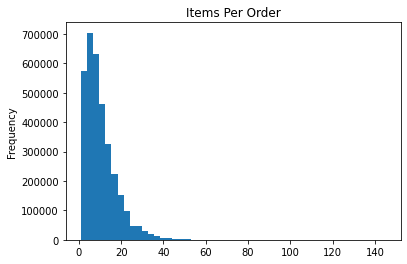

In [8]:
# order average length histogram
items_in_order = order_products.groupby('order_id').size()

# box plot is too hard to see just print
print("min", items_in_order.min())
print("0.25", items_in_order.quantile(0.25))
print("0.50", items_in_order.quantile(0.50))
print("0.75", items_in_order.quantile(0.75))
print("max", items_in_order.max())
print()

# histogram
items_in_order.plot(kind='hist', bins=50).set_title('Items Per Order');

## split data into windows

In [ ]:
# Grab a coffee/tea. 
# Save orders into corpus file for faster processing
with open("corpus.txt", "w") as f:

  grouped_df = (order_products.sort_values([
    'order_id', 
    'add_to_cart_order'
  ]).groupby('order_id'))

  lines = []
  written = 0
  for _, items in grouped_df:
      line = items['product_id'].astype('str').str.cat(sep=' ') + '\n'
      lines.append(line)
      if len(lines) > 100000:
        written += 100000
        print(f"Written {written} orders")
        f.writelines(lines)
        lines = []
  if len(lines) > 0:
    f.writelines(lines)

Written 100000 orders
Written 200000 orders
Written 300000 orders
Written 400000 orders
Written 500000 orders
Written 600000 orders
Written 700000 orders
Written 800000 orders
Written 900000 orders
Written 1000000 orders
Written 1100000 orders
Written 1200000 orders
Written 1300000 orders
Written 1400000 orders
Written 1500000 orders
Written 1600000 orders
Written 1700000 orders
Written 1800000 orders
Written 1900000 orders
Written 2000000 orders
Written 2100000 orders
Written 2200000 orders
Written 2300000 orders
Written 2400000 orders
Written 2500000 orders
Written 2600000 orders
Written 2700000 orders
Written 2800000 orders
Written 2900000 orders
Written 3000000 orders
Written 3100000 orders
Written 3200000 orders
Written 3300000 orders


In [9]:
vocab_freq = order_products.groupby('product_id').size().to_dict()

In [10]:
num_sentences = order_products['order_id'].nunique()

In [11]:
num_words = len(order_products)

## train word2vec on product_ids

In [37]:
WINDOW_SIZE = 7
NUM_WORKERS = 2
VECTOR_SIZE = 128

In [38]:
class EpochSaver(CallbackAny2Vec):

    '''Callback to save model after each epoch.'''
    def __init__(self, path_prefix):
        self.path_prefix = path_prefix
        self.epoch = 0

    def on_epoch_begin(self, model):
        print(f"Epoch {self.epoch} start")
    
    def on_epoch_end(self, model):
        output_path = f"{self.path_prefix}_epoch{self.epoch}.model"
        model.save(output_path)
        self.epoch += 1

In [39]:
epochsaver = EpochSaver("prod2vec")

In [40]:
# create skipgram word2vec model
model = Word2Vec( 
        vector_size=VECTOR_SIZE,
        window=WINDOW_SIZE,
        sg=1,
        min_count=1,
        seed=42,
        workers=NUM_WORKERS)

In [41]:
# build vocab directly from product_ids
# this works lot faster than entire pass
# over the dataset
model.build_vocab_from_freq(vocab_freq)

In [42]:
class SentenceGenerator(object):
  def __init__(self, file):
    self.file = file

  def __iter__(self):
    def readline():
      with open(self.file, 'r') as f:
        for line in f:
          yield [int(w) for w in line.split(" ")]
    return readline()

# gensim does not read file correctly if words are integer not string
gen = SentenceGenerator('corpus.txt')

In [43]:
# train word2vec model
model.train(gen, 
            epochs=10, 
            total_examples=num_sentences,
            callbacks=[epochsaver])

Epoch 0 start
Epoch 1 start
Epoch 2 start
Epoch 3 start
Epoch 4 start
Epoch 5 start
Epoch 6 start
Epoch 7 start
Epoch 8 start
Epoch 9 start


(325048178, 338191060)

## Look at few recommendations

In [44]:
# Look at random sample
products.sample(1)

,product_id,product_name,aisle_id,department_id
9950,9951,Outlast Long Lasting Mint Mouthwash,20,11


In [45]:
def find_similar(products, model, product_name, topn=10):

  # reindex for faster search
  products = products.set_index('product_id')

  # find product id
  product_id = products[products['product_name'] == product_name].iloc[0].name

  # most similar products
  similar = model.wv.most_similar(product_id, topn=topn)

  # product_id and score
  product_ids = [id for id, score in similar]
  scores = [score for id, score in similar]

  # return results
  products = products.loc[product_ids]
  products['score'] = scores

  return products

In [73]:
# product_name = "Chocolate Sandwich Cookies"
# product_name = "Snickers Chocolate Candy"
# product_name = "Vanilla Mint Moisturizing Conditioner"
product_name = "Dairy Free Greek Yogurt Strawberry"

print(f"Products similar to {product_name}")
find_similar(products, model, product_name, topn=10)

Products similar to Dairy Free Greek Yogurt Strawberry


,product_name,aisle_id,department_id,score
product_id,,,,
49570,Dairy Free Greek Yogurt Blueberry,120,16,0.906375
36835,Dairy Free Greek Yogurt Black Cherry,120,16,0.817927
5781,"Rice Vegan Slices, Cheddar Flavor",91,16,0.711014
40044,Chocolate Style Cheesecake,119,1,0.703339
48184,Soy Curls,107,19,0.687820
6123,Organic Raspberry Cultured Soy,120,16,0.681333
34323,Organic Blackberry Cultured Soy,120,16,0.668588
34673,Organic Plain Soy Yogurt,120,16,0.664820
21973,Dairy-Free Drinkable Cashewgurt Wild Blueberry...,100,21,0.655301



# save to drive

In [47]:
model.save('./prod2vec.model')

In [51]:
model.wv.save('prod2vec.wordvectors')

In [49]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [52]:
!cp ./prod2vec.model /gdrive/My\ Drive/prod2vec.model
!cp ./prod2vec.wordvectors /gdrive/My\ Drive/prod2vec.wordvectors

# visualize embeddings

In [53]:
# embedding vectors
embeddings = model.wv.vectors

# product ids
product_ids = model.wv.index_to_key

# department id of each product above
department_ids = products.set_index('product_id').loc[model.wv.index_to_key]['department_id']

# aisle id of each product above
aisle_ids = products.set_index('product_id').loc[model.wv.index_to_key]['aisle_id']

In [54]:
embeddings_2d = PCA(n_components=2).fit_transform(embeddings)

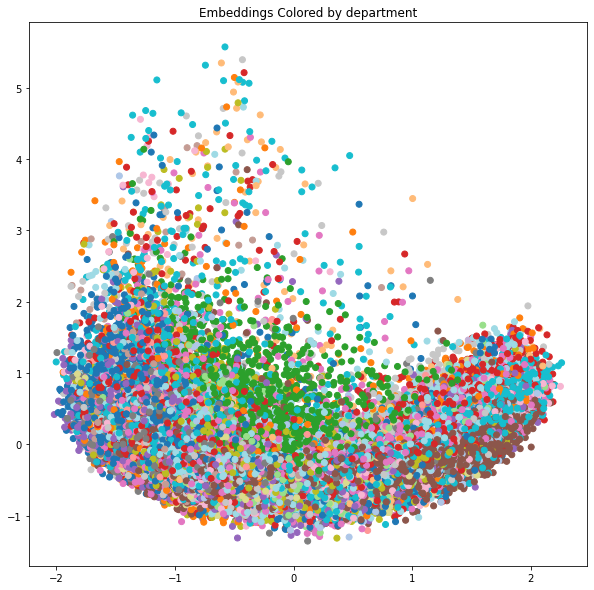

In [67]:
plt.figure(figsize=(10, 10))

plt.scatter(
    x=embeddings_2d[:, 0],
    y=embeddings_2d[:, 1],
    c=department_ids,
    cmap='tab20',
)

plt.title('Embeddings Colored by department');

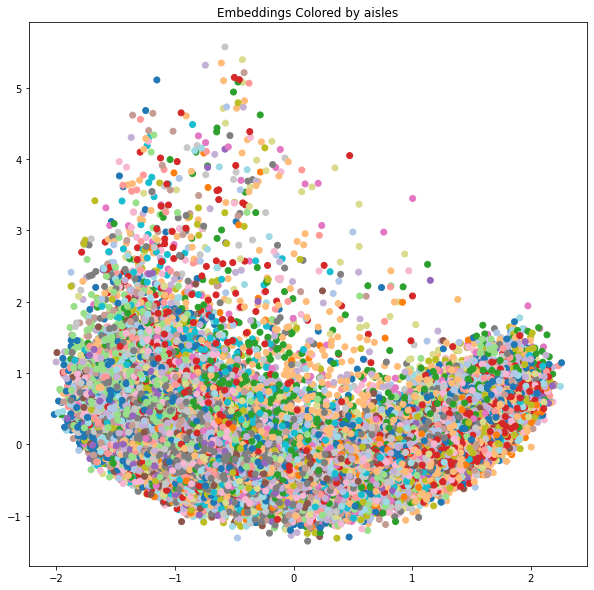

In [60]:
plt.figure(figsize=(10, 10))

plt.scatter(
    x=embeddings_2d[:, 0],
    y=embeddings_2d[:, 1],
    c=aisle_ids,
    cmap='tab20',
)

plt.title('Embeddings Colored by aisles');